# 1. Problema


El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago
de Chile (SCL). Para eso les entregamos un dataset usando datos públicos y reales donde cada fila corresponde a un vuelo
que aterrizó o despegó de SCL. Para cada vuelo se cuenta con la siguiente información:

* **Fecha-I** : Fecha y hora programada del vuelo.
* **Vlo-I** : Número de vuelo programado.
* **Ori-I** : Código de ciudad de origen programado.
* **Des-I** : Código de ciudad de destino programado.
* **Emp-I** : Código aerolínea de vuelo programado.
* **Fecha-O** : Fecha y hora de operación del vuelo.
* **Vlo-O** : Número de vuelo de operación del vuelo.
* **Ori-O** : Código de ciudad de origen de operación
* **Des-O** : Código de ciudad de destino de operación.
* **Emp-O** : Código aerolínea de vuelo operado.
* **DIA** : Día del mes de operación del vuelo.
* **MES** : Número de mes de operación del vuelo.
* **AÑO** : Año de operación del vuelo.
* **DIANOM** : Día de la semana de operación del vuelo.
* **TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional.
* **OPERA** : Nombre de aerolínea que opera.
* **SIGLAORI** : Nombre ciudad origen.
* **SIGLADES** : Nombre ciudad destino.

# 2. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from fast_ml.model_development import train_valid_test_split
import xgboost as xgb

import os
from pathlib import Path
from typing import List, Dict

In [2]:
#Se obtiene el path a data
notebooks_path = os.getcwd()
main_path = Path(notebooks_path).parent
data_path = main_path / "data"

In [3]:
raw_data_path = data_path / "raw/dataset_SCL.csv"
raw_data = pd.read_csv(raw_data_path)

# 3. Extra Features

In [24]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    preprocessed_data = (
        df
        .astype({
            'Fecha-I': "datetime64",
            'Fecha-O': "datetime64",
        })
    )

    return preprocessed_data

def add_delay_status_column(df: pd.DataFrame) -> pd.DataFrame:
    time_difference = df['Fecha-O'] - df['Fecha-I']
    minutes_difference = time_difference.dt.seconds.div(60).astype(int)
    df['delay_status'] = minutes_difference > 15
    df.loc[raw_data['Fecha-O'] < df['Fecha-I'], 'delay_status'] = False

    return df

def add_season_status_column(df: pd.DataFrame) -> pd.DataFrame:
    # High Season cases:
    # Dec 15 to Dec 31
    # Jan 1 to Mar 3
    # Jul 15 to Jul 31
    # Sep 11 to Sep 30 
    high_season_ranges = [
        ((12, 15), (12, 31)),
        ((1, 1), (3, 3)),
        ((7, 15), (7, 31)),
        ((9, 11), (9, 30))
    ]
    
    df['is_high_season'] = df['Fecha-I'].apply(
        lambda date: any(
            start <= (date.month, date.day) <= end
            for start, end in high_season_ranges
        )
    )
    
    return df

def add_minor_delay_column(df: pd.DataFrame) -> pd.DataFrame:
    time_difference = df['Fecha-O'] - df['Fecha-I']
    minutes_difference = time_difference.dt.seconds.div(60).astype(int)
    df['minor_delay'] = (minutes_difference <= 15) & (minutes_difference > 0)

    return df

def add_minutes_diff_column(df: pd.DataFrame) -> pd.DataFrame:
    time_difference = df['Fecha-O'] - df['Fecha-I']
    df['minutes_diff'] = time_difference.dt.seconds.div(60).astype(int)

    return df

def add_day_period_column(df: pd.DataFrame) -> pd.DataFrame:
    day_periods = {
        'morning': (5, 12),
        'afternoon': (12, 19),
        'evening_one': (19, 24),
        'evening_two': (0, 5)
    }
    
    df['day_period'] = df['Fecha-I'].apply(
        lambda datetime: next((period for period, hours in day_periods.items() if hours[0] <= datetime.hour < hours[1]), None)
    )

    df.loc[df['day_period'].isin(['evening_one', 'evening_two']), 'day_period'] = 'evening'
    
    return df

def process_data(raw_data: pd.DataFrame) -> pd.DataFrame:
    processed_data = (
        raw_data
        .pipe(preprocess_data)
        .pipe(add_day_period_column)
        .pipe(add_season_status_column)
        .pipe(add_delay_status_column)
        .pipe(add_minutes_diff_column)
        .pipe(add_minor_delay_column)
    )
    
    return processed_data

In [25]:
processed_data = process_data(raw_data)
processed_data

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,day_period,is_high_season,delay_status,minutes_diff,minor_delay
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,Domingo,I,American Airlines,Santiago,Miami,evening,True,False,3,True
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,Lunes,I,American Airlines,Santiago,Miami,evening,True,False,9,True
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,Martes,I,American Airlines,Santiago,Miami,evening,True,False,9,True
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,Miercoles,I,American Airlines,Santiago,Miami,evening,True,False,3,True
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,Jueves,I,American Airlines,Santiago,Miami,evening,True,False,1438,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,...,Viernes,I,JetSmart SPA,Santiago,Lima,afternoon,True,True,46,False
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,...,Lunes,I,JetSmart SPA,Santiago,Lima,afternoon,True,True,16,False
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,...,Miercoles,I,JetSmart SPA,Santiago,Lima,afternoon,True,True,40,False
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,...,Viernes,I,JetSmart SPA,Santiago,Lima,afternoon,True,False,13,True


In [27]:
# Guardando synthetic_features.csv
processed_data.loc[:, ['is_high_season', 'day_period', 'minor_delay', "minutes_diff"]].to_csv(data_path / "interim" / "synthetic_features.csv", index=False)

# 4. EDA

## 4.1 Tipo datos, nulos y duplicados

In [121]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha-I         68206 non-null  datetime64[ns]
 1   Vlo-I           68206 non-null  object        
 2   Ori-I           68206 non-null  object        
 3   Des-I           68206 non-null  object        
 4   Emp-I           68206 non-null  object        
 5   Fecha-O         68206 non-null  datetime64[ns]
 6   Vlo-O           68205 non-null  object        
 7   Ori-O           68206 non-null  object        
 8   Des-O           68206 non-null  object        
 9   Emp-O           68206 non-null  object        
 10  DIA             68206 non-null  int64         
 11  MES             68206 non-null  int64         
 12  AÑO             68206 non-null  int64         
 13  DIANOM          68206 non-null  object        
 14  TIPOVUELO       68206 non-null  object        
 15  OP

* Existe 1 solo dato con un campo nulo en Vlo-O
* La llave principal no se indica pero probablemente tenga relación con la fecha de operación, el número de vuelo, tipo de vuelo. También, podría ser quien lo opera pero veremos si hay alguna diferencía. 

In [122]:
(
    processed_data
    .drop_duplicates(subset=['Fecha-O', 'Vlo-O', 'TIPOVUELO', 'OPERA'])
    .shape
)

(68206, 21)

In [123]:
(
    processed_data
    .drop_duplicates(subset=['Fecha-O', 'Vlo-O', 'TIPOVUELO'], keep=False)
    .shape
)

(68192, 21)

In [124]:
possible_primary_keys = ['Fecha-O', 'Vlo-O', 'TIPOVUELO']
(
    processed_data
    .merge(
        (
            processed_data
            .drop_duplicates(subset=possible_primary_keys, keep=False)
            .loc[:, possible_primary_keys]
        ),
        on=possible_primary_keys,
        how="outer",
        indicator=True
    )
    .query("_merge == 'left_only'")
    .drop(columns="_merge")
    .sort_values(by=possible_primary_keys)
)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,day_period,is_high_season,delay_status
23842,2017-05-14 09:25:00,150,SCEL,SCFA,SKU,2017-05-14 09:28:00,150,SCEL,SCFA,SKU,...,5,2017,Domingo,N,Sky Airline,Santiago,Antofagasta,morning,False,False
23843,2017-05-14 09:35:00,150,SCEL,SCCF,LAN,2017-05-14 09:28:00,150,SCEL,SCCF,LAN,...,5,2017,Domingo,N,Grupo LATAM,Santiago,Calama,morning,False,False
28940,2017-06-05 15:25:00,130,SCEL,SCCF,SKU,2017-06-05 15:29:00,130,SCEL,SCCF,SKU,...,6,2017,Lunes,N,Sky Airline,Santiago,Calama,afternoon,False,False
28941,2017-06-05 15:25:00,130,SCEL,SCFA,LAN,2017-06-05 15:29:00,130,SCEL,SCFA,LAN,...,6,2017,Lunes,N,Grupo LATAM,Santiago,Antofagasta,afternoon,False,False
28890,2017-06-16 06:15:00,120,SCEL,SCCF,SKU,2017-06-16 06:17:00,120,SCEL,SCCF,SKU,...,6,2017,Viernes,N,Sky Airline,Santiago,Calama,morning,False,False
28891,2017-06-16 06:05:00,120,SCEL,SCFA,LAN,2017-06-16 06:17:00,120,SCEL,SCFA,LAN,...,6,2017,Viernes,N,Grupo LATAM,Santiago,Antofagasta,morning,False,False
28955,2017-06-19 15:25:00,130,SCEL,SCCF,SKU,2017-06-19 15:27:00,130,SCEL,SCCF,SKU,...,6,2017,Lunes,N,Sky Airline,Santiago,Calama,afternoon,False,False
28956,2017-06-19 15:25:00,130,SCEL,SCFA,LAN,2017-06-19 15:27:00,130,SCEL,SCFA,LAN,...,6,2017,Lunes,N,Grupo LATAM,Santiago,Antofagasta,afternoon,False,False
34301,2017-07-13 18:05:00,138,SCEL,SCCF,SKU,2017-07-13 18:24:00,138,SCEL,SCCF,SKU,...,7,2017,Jueves,N,Sky Airline,Santiago,Calama,afternoon,False,True
34302,2017-07-13 16:59:00,138,SCEL,SCFA,LAN,2017-07-13 18:24:00,138,SCEL,SCFA,LAN,...,7,2017,Jueves,N,Grupo LATAM,Santiago,Antofagasta,afternoon,False,True


Estos datos podrían estar duplicados, parecen ser un cambio de aerolíneas pero con la información dada no es posible confirmar esto, por lo que se va a considerar que no existe ningún dato duplicado.

## 4.1 Análisis univariado

In [125]:
def plot_frequency(df: pd.DataFrame, column: str, desired_order: List[str] = None):
    plt.figure(figsize = (20,6))
    sns.set(style="darkgrid")
    if desired_order: df[column].value_counts().loc[desired_order].plot(kind='bar')
    else: df[column].value_counts().plot(kind='bar')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Frequency of {column}')
    plt.xticks(rotation=90)
    plt.show()

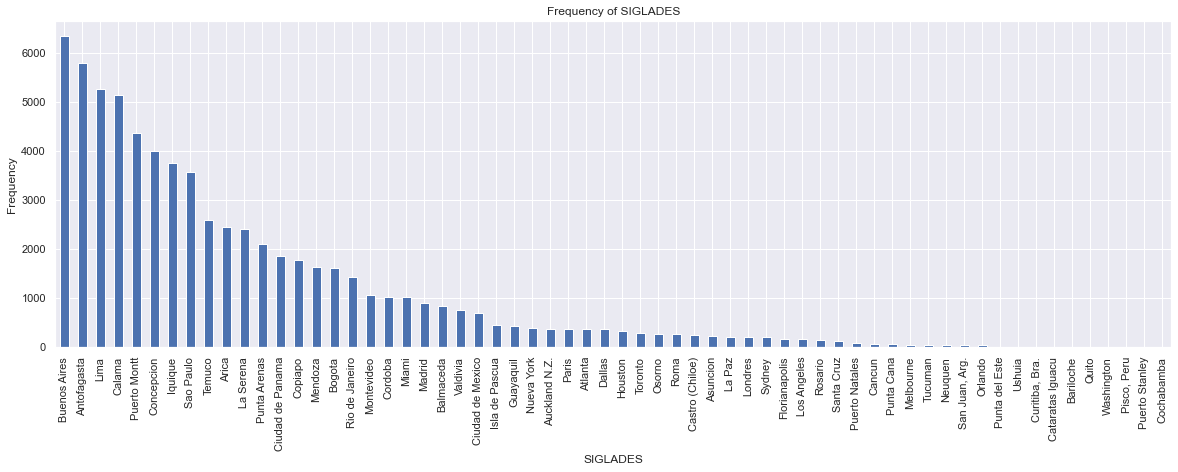

In [126]:
plot_frequency(processed_data, 'SIGLADES')

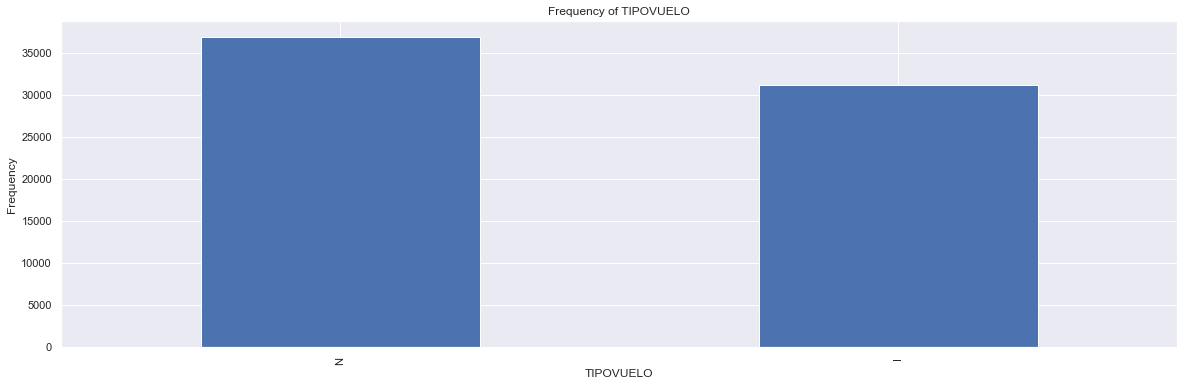

In [127]:
plot_frequency(processed_data, 'TIPOVUELO')

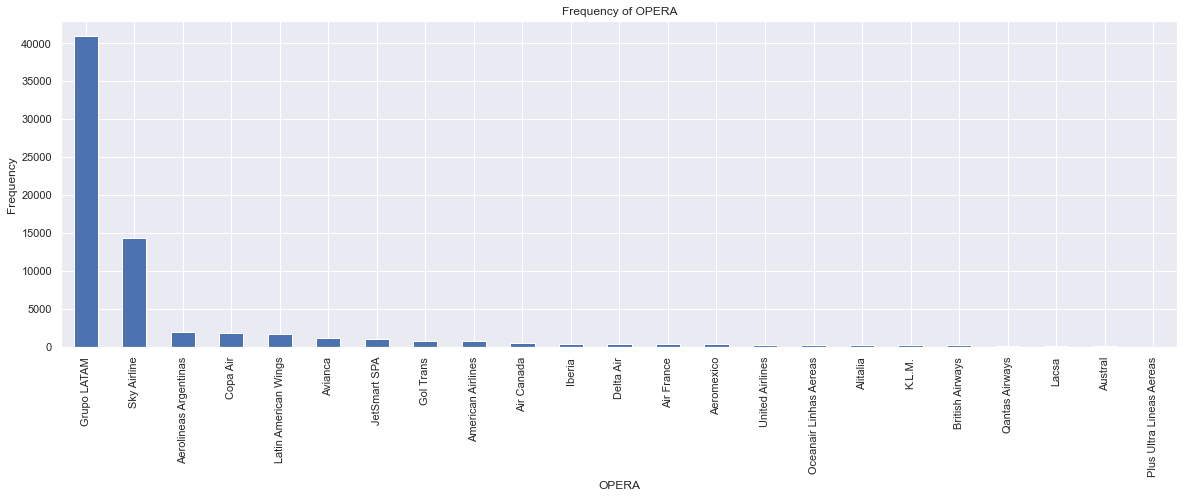

In [128]:
plot_frequency(processed_data, 'OPERA')

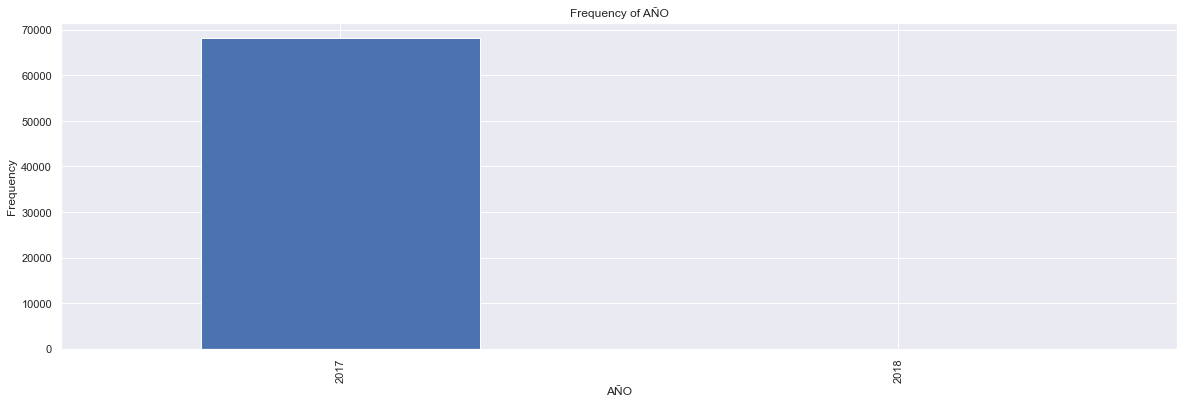

In [129]:
plot_frequency(processed_data, 'AÑO')

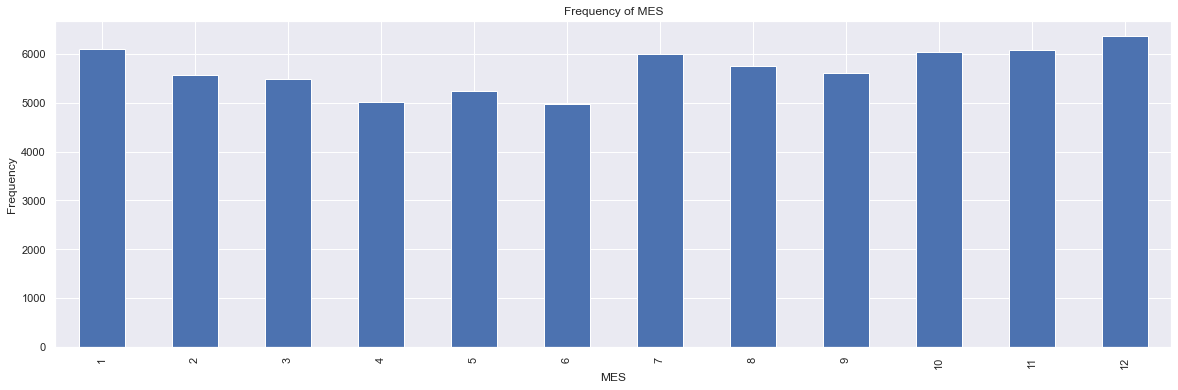

In [136]:
plot_frequency(processed_data, 'MES', desired_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

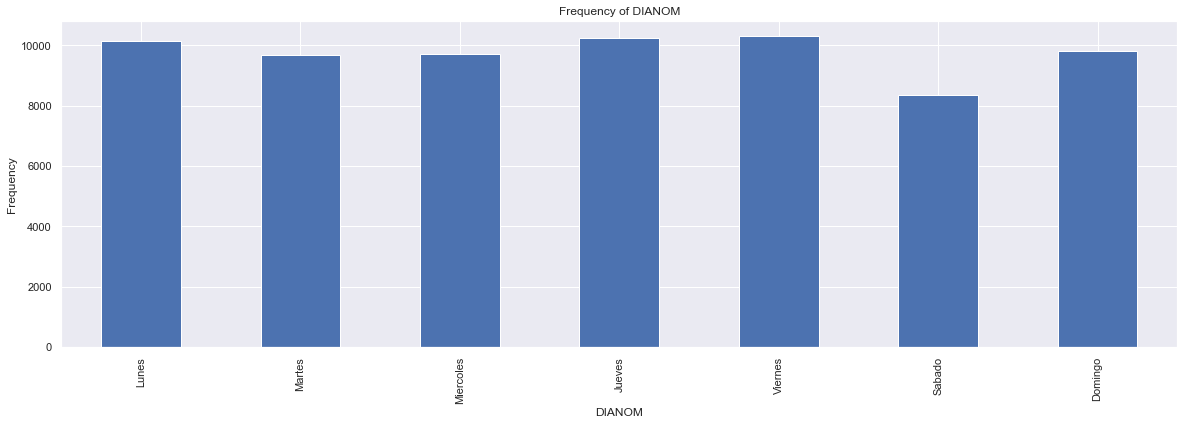

In [131]:
plot_frequency(processed_data, 'DIANOM', desired_order=["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"])

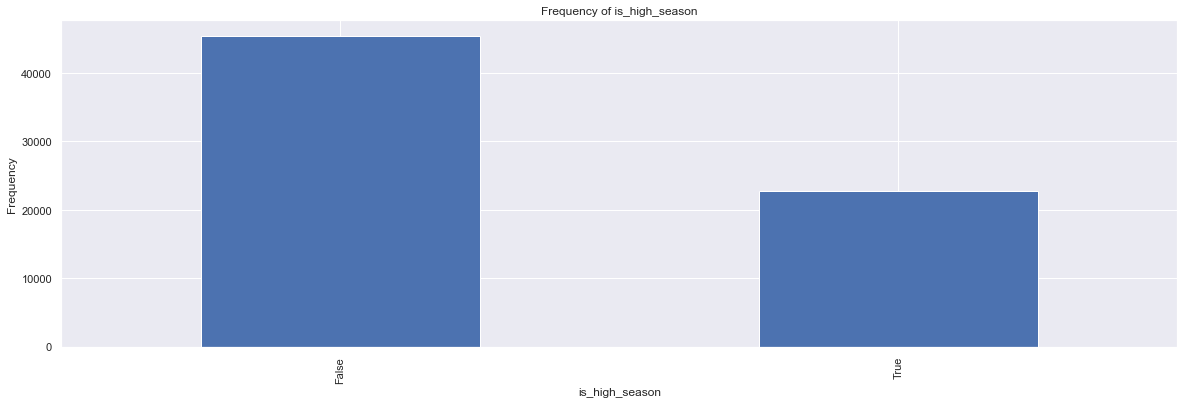

In [132]:
plot_frequency(processed_data, 'is_high_season')

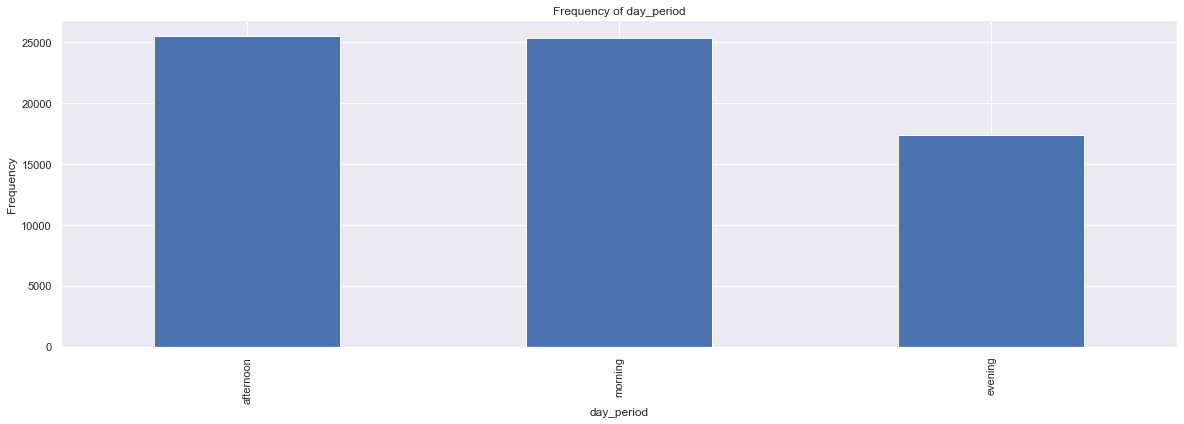

In [133]:
plot_frequency(processed_data, 'day_period')

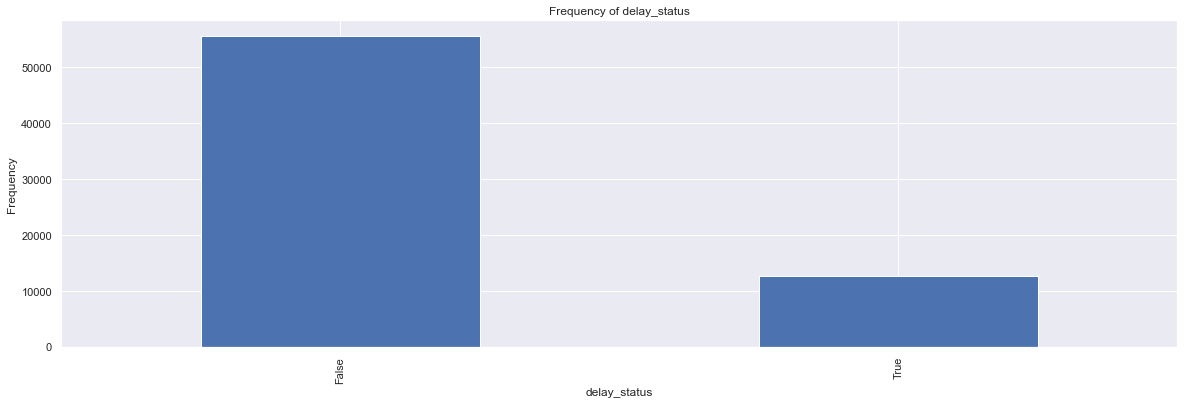

In [134]:
plot_frequency(processed_data, 'delay_status')

**RESUMEN**

* Gran parte de los vuelos son a destinos de Latam, donde destacan Buenos Aires, Lima y el norte de Chile. Buenos Aires y Lima probablemente se repiten mucho por ser lugares turísticos muy frecuentados, mientras que el norte de Chile probablemente se destaque debido al desplazamiento de trabajadores mineros.
* En el dataset se encuentran equilibrados los vuelos nacionales e internacionales.
* Latam lidera como operador de vuelos y en segundo lugar se encuentra Sky Airlines. El resto de aerolíneas tienen muy pocos vuelos en el dataset.
* Los datos son casi todos del 2017.
* Desde octubre hasta enero y julio por separado parece ser temporada alta, lo cual discrepa con el enunciado.
* Se destaca la poca cantidad de vuelos los días sábados.
* Se destaca la poca cantidad de vuelos por la noche.
* Se puede ver que el dataset es desbalanceado, la mayoría de los datos son de vuelos que no se atrasaron.

## 4.1 Análisis bivariado

En esta parte del análisis nos enfocaremos principalmente en ver la relación que existe entre las features y el atrazo de los vuelos

In [285]:
def plot_relationship_with_delay(df: pd.DataFrame, categorical_column: str, desired_order: List[str] = None):
    grouped_data = df.groupby(categorical_column)['delay_status'].mean().reset_index()
    frequency = df[categorical_column].value_counts().reset_index()
    frequency.columns = [categorical_column, 'frequency']
    merged_data = pd.merge(frequency, grouped_data, on=categorical_column)
    merged_data.set_index(categorical_column, inplace=True)
    if desired_order: merged_data = merged_data.reindex(desired_order)

    _, ax = plt.subplots(figsize = (20,10))
    merged_data.plot(use_index=True, kind='bar', y='delay_status', ax=ax, color='salmon')
    merged_data.plot(use_index=True, y='frequency', ax=ax, secondary_y=True, color='blue')
    plt.title(f'Delay Rate by {categorical_column}')
    ax.tick_params(labelrotation=90)
    plt.show()

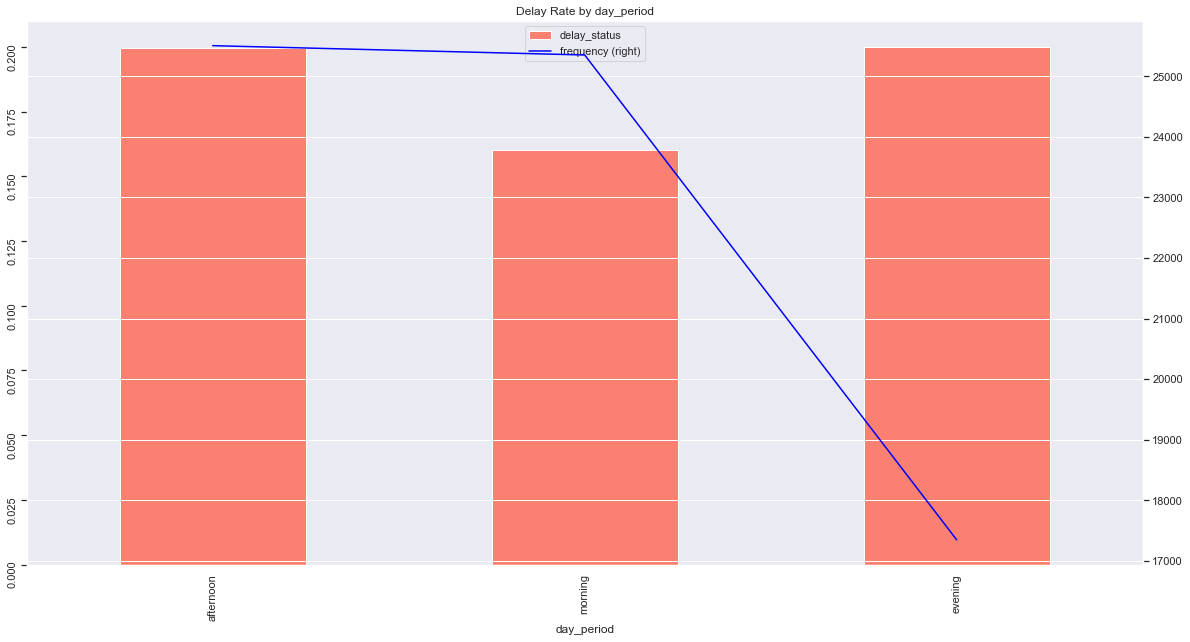

In [286]:
plot_relationship_with_delay(processed_data, 'day_period')

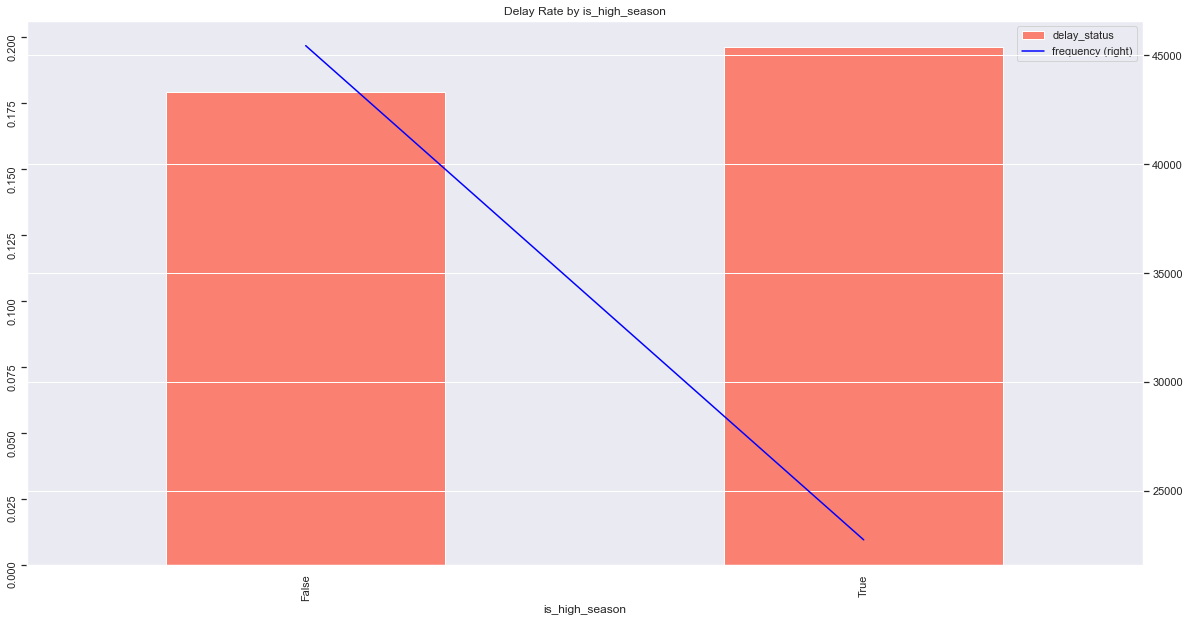

In [287]:
plot_relationship_with_delay(processed_data, 'is_high_season')

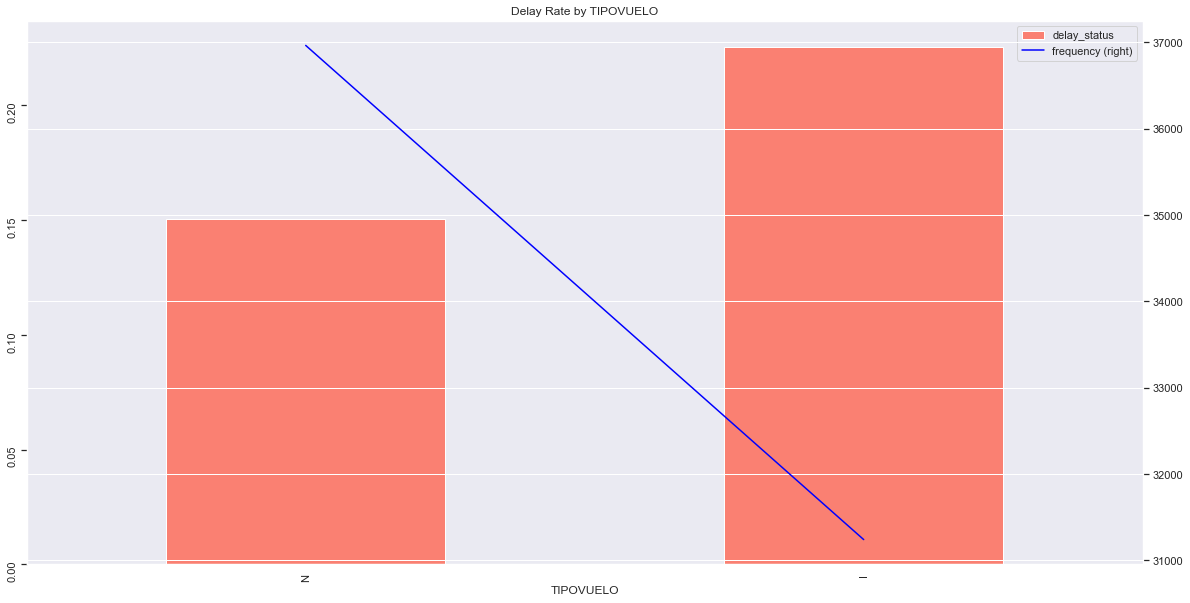

In [292]:
plot_relationship_with_delay(processed_data, 'TIPOVUELO')

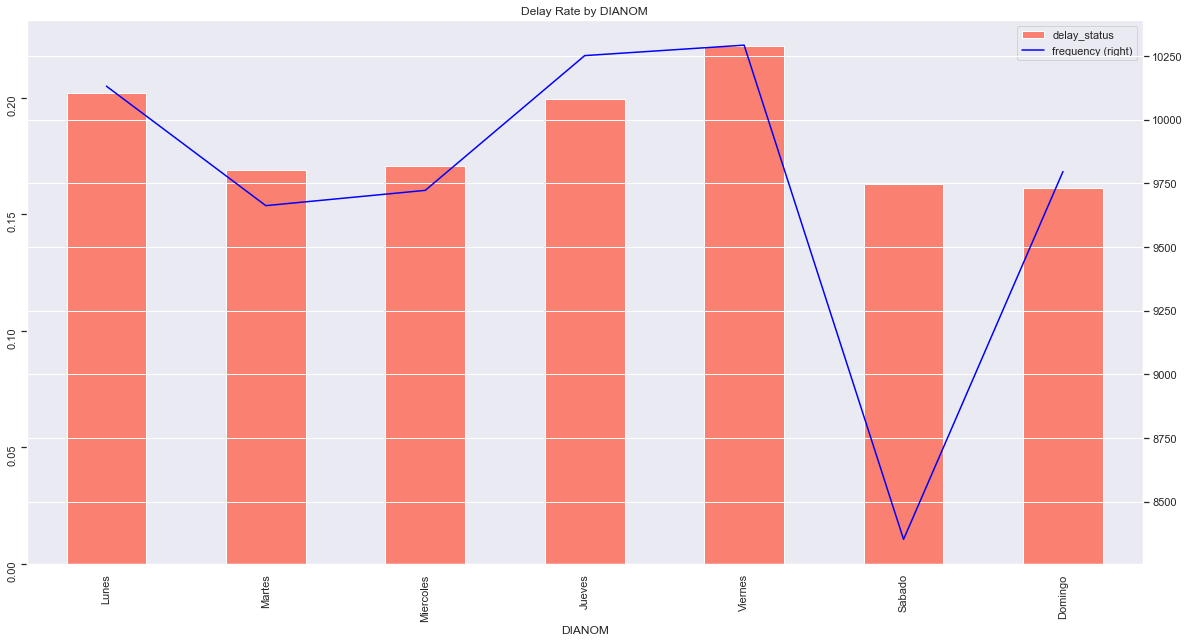

In [288]:
plot_relationship_with_delay(processed_data, 'DIANOM', desired_order=["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"])

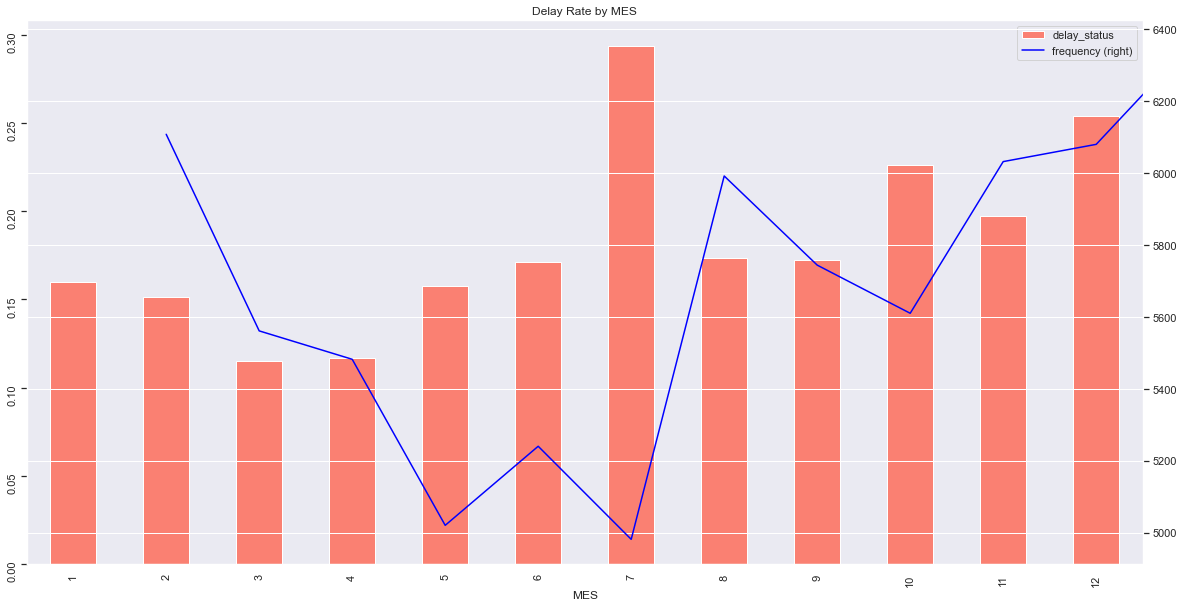

In [289]:
plot_relationship_with_delay(processed_data, 'MES', desired_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

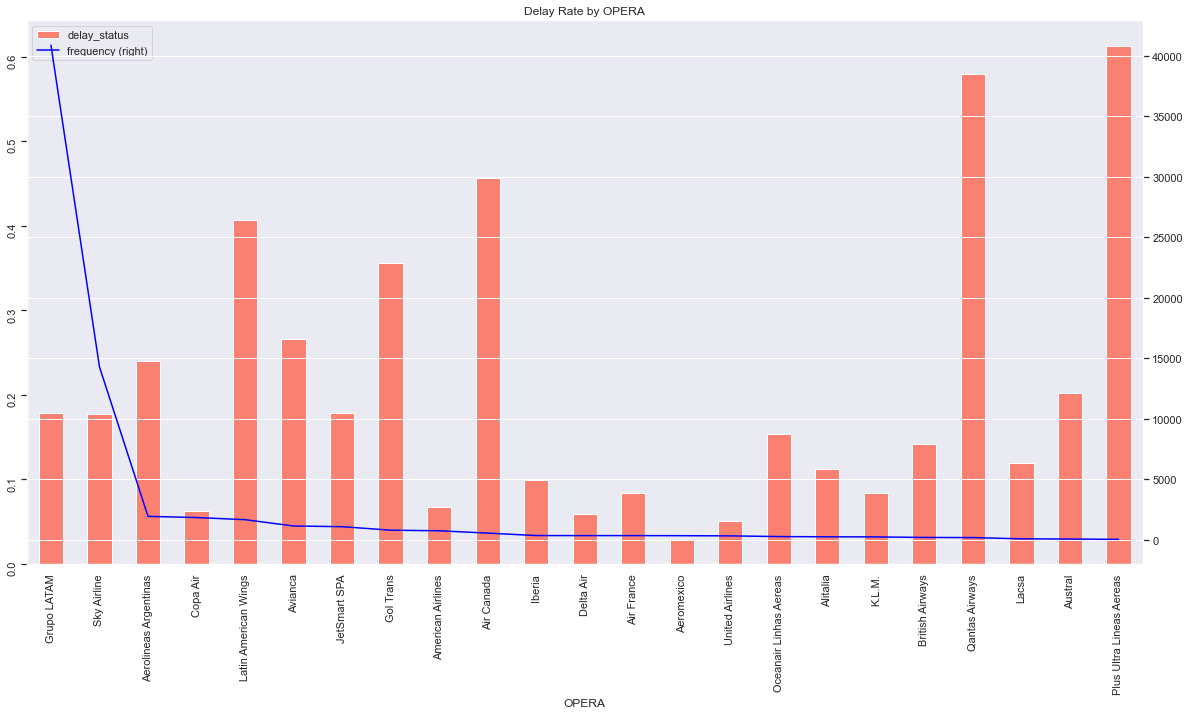

In [290]:
plot_relationship_with_delay(processed_data, 'OPERA')

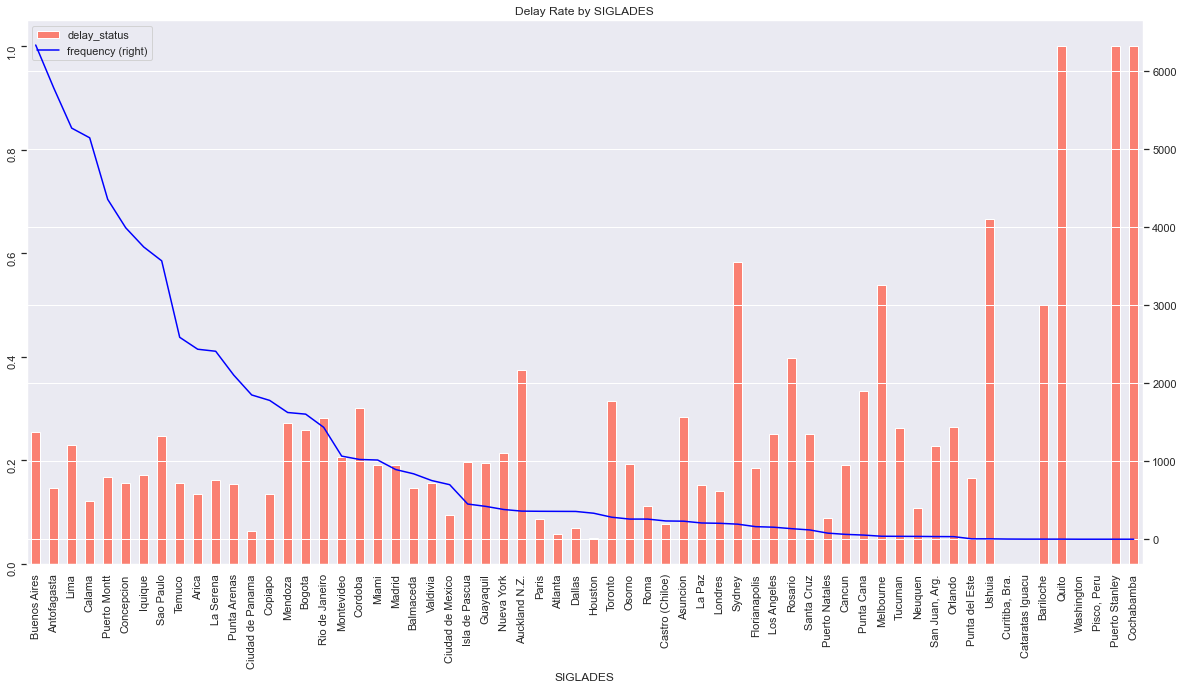

In [291]:
plot_relationship_with_delay(processed_data, 'SIGLADES')

**RESUMEN**

* Podemos ver que en los vuelos que se realizan en la mañana tienen una menor tasa de retraso. Esto podría deberse a que durante la mañana hay más personal disponible trabajando, mientras que en la tarde pueden haber menos disponibles por pausas como el almuerzo, y en la noche puede que se tenga menos personal debido a que puede ser más caro pagar dichos horarios al personal.
* Se observa que los vuelos internacionales tienen una mayor tasa de retraso. Probablemente se debe a que los requisitos para vuelos internacionales son más complejos o a condiciones climáticas.
* En los días de la semana se puede ver que existe una relación entre mayor cantidad de vuelos y la tasa de retraso.
* En los meses podemos ver que existe una relación entre la tasa de retraso y las estaciones del año. Esto probablemente se deba al clima.
* Se observa que existen grandes diferencias entre operadores en sus tasas de retraso, lo cual probablemente se deba a la calidad del servicio que ofrecen.
* No parece existir una relación entre la tasa de retraso y el destino del vuelo. Hay algunos países en los cuales la tasa de retraso es alta, pero la cantidad de vuelos que hay a esos países es demasiado baja; se podrían considerar como outliers. Existe una diferencia clara entre ciertos destinos, pero siguen la lógica de los vuelos nacionales e internacionales, en donde los vuelos internacionales tienen una mayor tasa de retraso.

# 5. Modelamiento

Para el modelamiento se escogió la métrica ROC AUC, dado que el dataset es desbalanceado y es independiente del umbral seleccionado.

In [21]:
RANDOM_STATE = 42

In [6]:
def transform_to_numpy(X: pd.DataFrame, columns: List[str]) -> np.array:
    return X.loc[:, columns].to_numpy()

def create_category_encoder(X_train: pd.DataFrame, y_train: pd.DataFrame, columns: list) -> ce.GLMMEncoder:
    category_encoder = ce.GLMMEncoder(binomial_target = True)
    category_encoder.fit(X_train[columns], y_train)
    return category_encoder

def encode_category_columns(X: pd.DataFrame, category_encoder: ce.GLMMEncoder) -> np.array:
    columns = category_encoder.feature_names_out_
    return category_encoder.transform(X[columns])

def create_label_encoders(columns_with_values: Dict) -> dict:
    label_encoders = {}
    for column in columns_with_values.keys():
        le = LabelEncoder()
        le.fit(columns_with_values[column])
        label_encoders[column] = le
    return label_encoders

def encode_label_columns(X: pd.DataFrame, label_encoders: Dict) -> np.array:
    label_encodes = np.array([])
    for column in label_encoders.keys():
        results = label_encoders[column].transform(X[column])
        results = results.reshape(results.shape[0], 1)
        if label_encodes.size == 0: 
            label_encodes = results
            continue
        label_encodes = np.concatenate((label_encodes, results), axis=1)
    return label_encodes

def encode_dataset(X: pd.DataFrame, category_encoder: ce.GLMMEncoder, label_encoders: dict, columns_to_numpy: list) -> np.array:
    not_encoded_variables = transform_to_numpy(X=X, columns=columns_to_numpy)
    label_encodes = encode_label_columns(X=X, label_encoders=label_encoders)
    category_encodes = encode_category_columns(X=X, category_encoder=category_encoder)
    return np.concatenate([not_encoded_variables, label_encodes, category_encodes], axis=1)

In [47]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(processed_data, target='delay_status', train_size=0.7, valid_size=0.2, test_size=0.1, random_state=RANDOM_STATE)

In [48]:
category_encoders_columns = ['Des-I', 'Emp-I', 'Des-O', 'Emp-O', 'TIPOVUELO', 'is_high_season']
category_encoder = create_category_encoder(X_train=X_train, y_train=y_train, columns=category_encoders_columns)

label_columns_with_values = {
    'DIANOM': ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"], 
    'day_period': ["morning", "afternoon", "evening"]
}
label_encoders = create_label_encoders(columns_with_values=label_columns_with_values)

columns_to_numpy = ['DIA', 'MES', 'AÑO']

X_train_encoded = encode_dataset(X=X_train, category_encoder=category_encoder, label_encoders=label_encoders, columns_to_numpy=columns_to_numpy)
X_valid_encoded = encode_dataset(X=X_valid, category_encoder=category_encoder, label_encoders=label_encoders, columns_to_numpy=columns_to_numpy)
X_test_encoded = encode_dataset(X=X_test, category_encoder=category_encoder, label_encoders=label_encoders, columns_to_numpy=columns_to_numpy)

## 5.1 Modelo base

In [49]:
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)

In [50]:
roc_auc_score(y_test, y_pred)

0.50592181011867

El modelo base tiene un resultado ROC AUC de 0.5 lo cual implica que no es mejor que un modelo que intenta adivinar al azar. Por lo que vamos a intentar mejorar esto.

## 5.2 Modelo con XGBoost

Para selecionar los parametros se utilizara cross validation por lo que uniremos los datos de entrenamiento y valdiación

In [56]:
X_train_valid_encoded = np.concatenate((X_train_encoded, X_valid_encoded), axis=0)
y_train_valid = np.concatenate((y_train, y_valid), axis=0)

In [57]:
parameters_grid = {'max_depth': [4, 6, 20], 
                   'learning_rate': [0.1, 0.3],
                   'n_estimators': [50, 100], 
                   'gamma': [0, 20], 
                   'lambda': [0.1, 1],
                   'scale_pos_weight': [5, 10],
                   'tree_method': ['hist']}

model = xgb.XGBClassifier()

xgb_gscv = GridSearchCV(model, parameters_grid, cv=2, scoring='roc_auc', return_train_score=True, verbose=3, n_jobs=1)
xgb_gscv.fit(X_train_valid_encoded, y_train_valid)

Fitting 2 folds for each of 96 candidates, totalling 192 fits
[CV 1/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=4, n_estimators=50, scale_pos_weight=5, tree_method=hist;, score=(train=0.719, test=0.694) total time=   0.1s
[CV 2/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=4, n_estimators=50, scale_pos_weight=5, tree_method=hist;, score=(train=0.714, test=0.704) total time=   0.1s
[CV 1/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=4, n_estimators=50, scale_pos_weight=10, tree_method=hist;, score=(train=0.718, test=0.693) total time=   0.1s
[CV 2/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=4, n_estimators=50, scale_pos_weight=10, tree_method=hist;, score=(train=0.714, test=0.703) total time=   0.1s
[CV 1/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=4, n_estimators=100, scale_pos_weight=5, tree_method=hist;, score=(train=0.740, test=0.705) total time=   0.1s
[CV 2/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=4, n_es

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'gamma': [0, 20], 'lambda': [0.1, 1],
                         'learning_rate': [0.1, 0.3], 'max_depth': [4, 6, 20],
                         'n_estimators': [50, 100], 'scale_pos_weight': [5, 10],
                         'tree_method': ['hist']},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [59]:
xgb_gscv.best_params_

{'gamma': 0,
 'lambda': 1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 100,
 'scale_pos_weight': 5,
 'tree_method': 'hist'}

In [58]:
params = {        
    'max_depth': 6, 
    'learning_rate': 0.1,
    'n_estimators': 100, 
    'gamma': 0, 
    'lambda': 1,
    'scale_pos_weight': 5,
    'tree_method': 'hist'
}
model = xgb.XGBClassifier(**params)
model.fit(X_train_encoded, y_train)

y_pred = model.predict_proba(X_train_encoded)[:, 1]
print("Training results")
print(f"roc auc: {roc_auc_score(y_train, y_pred)}")

print("Validation results")
y_pred = model.predict_proba(X_valid_encoded)[:, 1]
print(f"roc auc: {roc_auc_score(y_valid, y_pred)}")

Training results
roc auc: 0.7776196992529135
Validation results
roc auc: 0.732995310078707


Los resultados mejoraron bastante, pero podemos ver que existe over-fitting, por lo que ajustaremos parametros utlizando gridsearch que reducen el el over-fitting de los modelos.

In [74]:
parameters_grid = {'max_depth': [6, 4, 2], 
                   'learning_rate': [0.1],
                   'n_estimators': [100, 50, 25], 
                   'gamma': [0, 15, 30], 
                   'lambda': [0.1, 10, 20],
                   'scale_pos_weight': [5],
                   'subsample': [1, 0.8, 0.6, 0.4],
                   'max_leaves': [0, 2, 4, 6, 8, 30, 40],
                   'min_child_weight': [1, 0.8, 0.6, 0.4],
                   'tree_method': ['hist']
                   }

model = xgb.XGBClassifier()

xgb_gscv = GridSearchCV(model, parameters_grid, cv=2, scoring='roc_auc', return_train_score=True, verbose=3, n_jobs=1)
xgb_gscv.fit(X_train_valid_encoded, y_train_valid)

Fitting 2 folds for each of 720 candidates, totalling 1440 fits
[CV 1/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=6, max_leaves=0, min_child_weight=1, n_estimators=100, scale_pos_weight=5, subsample=1, tree_method=hist;, score=(train=0.806, test=0.715) total time=   0.1s
[CV 2/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=6, max_leaves=0, min_child_weight=1, n_estimators=100, scale_pos_weight=5, subsample=1, tree_method=hist;, score=(train=0.799, test=0.722) total time=   0.1s
[CV 1/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=6, max_leaves=0, min_child_weight=1, n_estimators=100, scale_pos_weight=5, subsample=0.8, tree_method=hist;, score=(train=0.810, test=0.713) total time=   0.1s
[CV 2/2] END gamma=0, lambda=0.1, learning_rate=0.1, max_depth=6, max_leaves=0, min_child_weight=1, n_estimators=100, scale_pos_weight=5, subsample=0.8, tree_method=hist;, score=(train=0.806, test=0.722) total time=   0.1s
[CV 1/2] END gamma=0, lambda=0.1, learning_rate=

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=1,
             param_grid={'gamma': [0], 'lambda': [0.1], 'learning_rate': [0.1],
                         'max_depth': [6, 4, 2], 'max_leaves': [0, 2, 4, 6, 8],
                         'min_child_weight': [1, 0.8, 0.6, 0.4],
                         'n_estimators': [100, 50, 25], 'scale_pos_weight': [5],
                         'subsample': [1, 0.8, 0.6, 0.4],
                         'tree_method': ['hist']},
             return_train_score=True, scoring='roc_auc', verbose=3)

In [75]:
cv_results = xgb_gscv.cv_results_
cv_results = pd.concat([pd.DataFrame(cv_results["params"]),
                        pd.DataFrame(cv_results["mean_test_score"], columns=["test_roc_auc"]),
                        pd.DataFrame(cv_results["mean_train_score"], columns=["train_roc_auc"])],
                       axis=1)
print(cv_results.sort_values(by="test_roc_auc", ascending=False).reset_index(drop=True))

     gamma  lambda  learning_rate  max_depth  max_leaves  min_child_weight  \
0        0     0.1            0.1          6           0               0.8   
1        0     0.1            0.1          6           0               0.6   
2        0     0.1            0.1          6           0               1.0   
3        0     0.1            0.1          6           0               0.4   
4        0     0.1            0.1          6           0               1.0   
..     ...     ...            ...        ...         ...               ...   
715      0     0.1            0.1          2           2               0.4   
716      0     0.1            0.1          6           2               0.6   
717      0     0.1            0.1          2           2               0.8   
718      0     0.1            0.1          2           2               1.0   
719      0     0.1            0.1          2           2               0.6   

     n_estimators  scale_pos_weight  subsample tree_method  tes

In [116]:
params = {
    'gamma': 15,
    'lambda': 20,
    'learning_rate': 0.1,
    'max_depth': 18,
    'max_leaves': 40,
    'min_child_weight': 0.2,
    'n_estimators': 55,
    'scale_pos_weight': 5,
    'subsample': 0.7,
    'tree_method': 'hist'
}

model = xgb.XGBClassifier(**params)
model.fit(X_train_encoded, y_train)

y_pred = model.predict_proba(X_train_encoded)[:, 1]
print("Training results")
print(f"roc auc: {roc_auc_score(y_train, y_pred)}")

print("Validation results")
y_pred = model.predict_proba(X_valid_encoded)[:, 1]
print(f"roc auc: {roc_auc_score(y_valid, y_pred)}")

Training results
roc auc: 0.7342172126853151
Validation results
roc auc: 0.7223550821160223


Podemos ver que se redujo el overfitting manteniendo un buen score de roc auc para los datos de validación

In [117]:
print("Test results")
y_pred = model.predict_proba(X_test_encoded)[:, 1]
print(f"roc auc: {roc_auc_score(y_test, y_pred)}")

Test results
roc auc: 0.7330473471777819


Podemos ver que en los datos de test se logro una generalización al nivel de los datos de entrenamiento. Por lo que, este es el modelo que utilizaremos.